In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Emulator tests

In [ ]:
from acm.projects.bgs import *
from acm.data.io_tools import summary_coords
from acm.observables.combined import BaseCombinedObservable as CombinedObservable

stat = CombinedObservable([
    GalaxyCorrelationFunctionMultipoles(),
    DensitySplitCorrelationFunctionMultipoles(),
])

mock_idx = 96

covariance_matrix = stat.get_covariance_matrix()
emulator_covariance_matrix = stat.get_emulator_covariance_matrix()
emulator_error = stat.emulator_error
data_error = np.sqrt(np.diag(covariance_matrix))


truth = stat.lhc_y[mock_idx]
pred = stat.get_model_prediction(stat.lhc_x[mock_idx])

# Separations
separations = []
for s in stat.observables:
    sc_dict = summary_coords(
        statistic=s.stat_name, 
        coord_type='emulator_error', # Get the statistic shape only (could be done by hand, but it's more elegant this way)
        bin_values=s.bin_values,
        summary_coords_dict=s.summary_coords_dict)
    dimensions = [len(val) for val in sc_dict.values()]
    data_length = np.prod(dimensions)
    separations.append(data_length)
separations = np.asarray(separations).cumsum() # Cumulative sum of separations to add the offset of each observable
separations = separations[:-1] # Remove the last element

if len(separations) == 0:
    separations = [] # No need to plot separations if there is only one observable

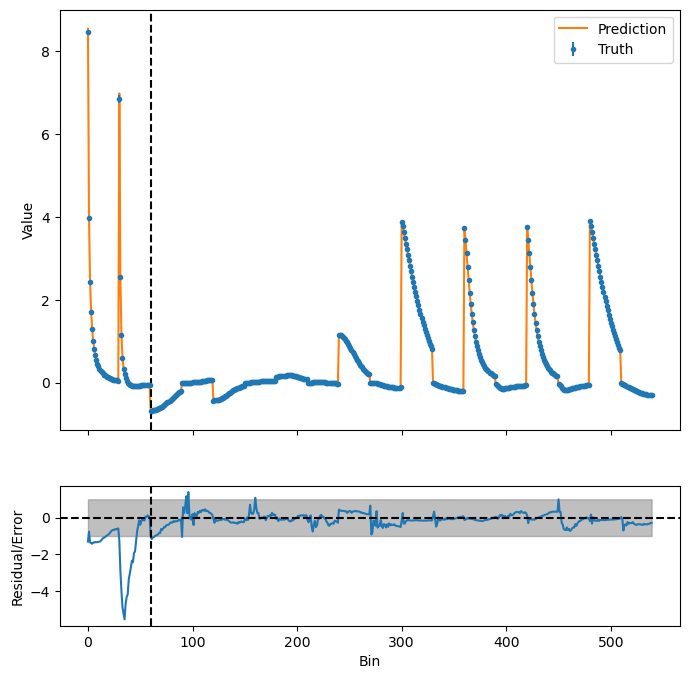

In [39]:
fix, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 8), height_ratios=[3, 1])

ax[0].plot(pred, label='Prediction', color='C1')
# ax[0].fill_between(list(range(len(truth))), pred - emulator_error, pred + emulator_error, color='C1', alpha=0.5)
ax[0].errorbar(list(range(len(truth))), truth, yerr=data_error, fmt='o', label='Truth', markersize=3, color='C0')


ax[1].plot((truth - pred)/data_error)
ax[1].axhline(0, color='k', linestyle='--')
ax[1].fill_between(list(range(len(truth))), -1, 1, color='gray', alpha=0.5)

for i in range(len(separations)):
    ax[0].axvline(separations[i], color='k', linestyle='--')
    ax[1].axvline(separations[i], color='k', linestyle='--')

ax[0].legend()

ax[1].set_xlabel('Bin')
ax[0].set_ylabel('Value')
ax[1].set_ylabel('Residual/Error');

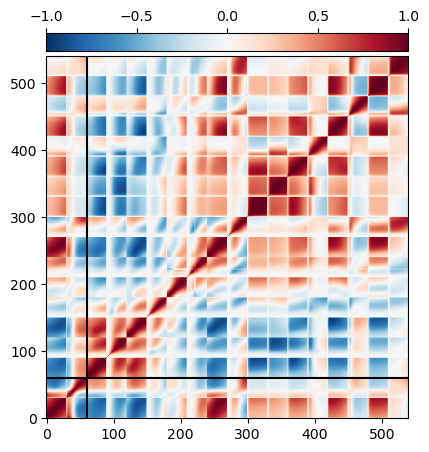

In [40]:
from acm.data.io_tools import correlation_from_covariance
from mpl_toolkits.axes_grid1 import make_axes_locatable

correlation_matrix = correlation_from_covariance(covariance_matrix)
    
fig, ax = plt.subplots(figsize=(5, 5))
cmap = plt.get_cmap('RdBu_r')

im = ax.imshow(correlation_matrix, origin='lower', cmap=cmap, vmin=-1, vmax=1)

for i in separations:
    ax.axvline(i, color='black')
    ax.axhline(i, color='black')

# Create colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='5%', pad=0.05)
cb = fig.colorbar(im,cax=cax, orientation="horizontal", fraction=0.046, pad=0.05, ticks=[-1, -0.5, 0, 0.5, 1]) #colorbar on top
cb.ax.xaxis.set_ticks_position('top')